# Hyperparameter testing for FraudHacker #
The FraudHacker model, at present, utilizes HDBSCAN in conjunction with a Global Outlier Score for Hierarchies (GLOSH) for outlier detection, which is qualitatively similar to the notion of a local outlier factor but includes hierarchical rankings in its consideration of what counts as an outlier.  FraudHacker, in this mode, has only two hyper-parameters:
* Minimum cluster size for HDBSCAN
* Threshold for outlier detection - in this case, what upper percentile of GLOSH scores count as outliers?

In [1]:
# Needed imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Need the source files for FraudHacker.
import sys
sys.path.append('/home/dan/PycharmProjects/fraudhacker/src')
from fh_config import regression_vars, response_var

Below we have a few sample data sets.  The focus right now is on FL because we know the most true positives for FL.  For rapid testing purposes, these were generated offline and pasted manually into the notebook. In the future we could pickle these or import them from an external configuration file, this is a bit messy!

In [96]:
rankings_dict_cardio_fl = {80: ['QAMAR', 'PAL', 'SEDILLO', 'GOEL', 'CHALASANI', 'LEW', 'REDDY', 'ATTANTI', 'MANUBENS', 'BAJAJ', 'GUMMADI', 'VAN DEN BERG', 'PRESSMAN', 'RANDALL', 'LIEBERMAN', 'UPADYA', 'STEIN', 'SESHADRI', 'KHATIB', 'GARCIA'], 20: ['QAMAR', 'SEDILLO', 'PAL', 'LEW', 'CHALASANI', 'ATTANTI', 'KHATIB', 'REDDY', 'GOEL', 'BREDLAU', 'GUALA', 'LEE', 'VAN DEN BERG', 'GARCIA', 'RANDALL', 'MANUBENS', 'BHATTA', 'RUGGIERI', 'ZACHARIAH', 'ROSENFIELD'], 150: ['QAMAR', 'SEDILLO', 'LEW', 'PAL', 'CHALASANI', 'KHATIB', 'ATTANTI', 'REDDY', 'UPADYA', 'GOEL', 'GUMMADI', 'LEE', 'TAUSSIG', 'WILLARD', 'GUALA', 'SINGH', 'ANDERSON', 'MANUBENS', 'DUBLIN', 'YELAMANCHI'], 40: ['QAMAR', 'PAL', 'SEDILLO', 'CHALASANI', 'ATTANTI', 'LEW', 'UPADYA', 'MANUBENS', 'REDDY', 'VAN DEN BERG', 'KHATIB', 'RUGGIERI', 'GOEL', 'ZACHARIAH', 'RANDALL', 'BHATTA', 'ALONSO', 'SECKLER', 'BREDLAU', 'LIEBERMAN'], 100: ['QAMAR', 'SEDILLO', 'LEW', 'CHALASANI', 'PAL', 'KHATIB', 'REDDY', 'ATTANTI', 'UPADYA', 'GOEL', 'GUMMADI', 'TAUSSIG', 'LEE', 'GUALA', 'WILLARD', 'RUGGIERI', 'SINGH', 'BASNIGHT', 'BAJAJ', 'ANDERSON'], 10: ['QAMAR', 'SEDILLO', 'PAL', 'LEW', 'REDDY', 'CHALASANI', 'LEE', 'KHATIB', 'LIEBERMAN', 'RUGGIERI', 'RANDALL', 'VANROY', 'ALI', 'VAN DEN BERG', 'MANUBENS', 'BREDLAU', 'STEIN', 'ATTANTI', 'FERNS', 'GUMMADI'], 15: ['QAMAR', 'SEDILLO', 'PAL', 'LEW', 'CHALASANI', 'VANROY', 'REDDY', 'LEE', 'BHATTA', 'KHATIB', 'LIEBERMAN', 'RANDALL', 'ATTANTI', 'PRESSMAN', 'RUGGIERI', 'BOSWELL', 'RUBENSTEIN', 'JAMIDAR', 'WILLARD', 'STEIN']}
rankings_dict_ophth_fl = {80: ['EATON', 'MELGEN', 'WAFAPOOR', 'BAUDO', 'WONG', 'MYERS', 'GUPTA', 'PATEL', 'RASKAUSKAS', 'KOSSLER', 'NIFFENEGGER', 'LAVINA', 'MAIZEL', 'GALLOGLY', 'ROSECAN', 'GREMILLION', 'SNYDER', 'LAMBROU', 'SULLIVAN', 'WALKER'], 20: ['MELGEN', 'EATON', 'WAFAPOOR', 'PATEL', 'GUPTA', 'MYERS', 'KOSSLER', 'BAUDO', 'MAIZEL', 'GREMILLION', 'ROSECAN', 'WONG', 'RASKAUSKAS', 'CHALAM', 'NIFFENEGGER', 'HALPERIN', 'SULLIVAN', 'WALKER', 'KATZ', 'GHUMAN'], 150: ['MELGEN', 'EATON', 'GUPTA', 'MYERS', 'MAIZEL', 'RASKAUSKAS', 'BAUDO', 'KOSSLER', 'GALLOGLY', 'GREMILLION', 'PATEL', 'TULI', 'HALPERIN', 'MALLON', 'WONG', 'WAFAPOOR', 'GHUMAN', 'NIFFENEGGER', 'KOSTICK', 'AKER'], 40: ['MELGEN', 'EATON', 'BAUDO', 'WAFAPOOR', 'WONG', 'PATEL', 'MYERS', 'GUPTA', 'HALPERIN', 'RASKAUSKAS', 'KOSSLER', 'LAVINA', 'ROSECAN', 'POWERS', 'NIFFENEGGER', 'GALLOGLY', 'MAIZEL', 'SNYDER', 'GREMILLION', 'LAMBROU'], 100: ['MELGEN', 'EATON', 'MYERS', 'GUPTA', 'MAIZEL', 'PATEL', 'GREMILLION', 'BAUDO', 'HALPERIN', 'KOSSLER', 'WONG', 'NIFFENEGGER', 'HENDERSON', 'WAFAPOOR', 'KATZ', 'LEPIK', 'RASKAUSKAS', 'KAY', 'GHUMAN', 'ARCARO'], 10: ['MELGEN', 'GUPTA', 'EATON', 'MYERS', 'SULLIVAN', 'WONG', 'NIFFENEGGER', 'WAFAPOOR', 'RASKAUSKAS', 'MAVROFRIDES', 'PATEL', 'BAUDO', 'GHUMAN', 'BARNARD', 'KOSSLER', 'APPIAH', 'STAMAN', 'BELLOTTE', 'GOROVOY', 'SMITHWICK'], 15: ['MELGEN', 'EATON', 'GUPTA', 'SULLIVAN', 'MYERS', 'RASKAUSKAS', 'BAUDO', 'WAFAPOOR', 'CHALAM', 'NIFFENEGGER', 'KOSSLER', 'STAMAN', 'PATEL', 'BARNARD', 'MAVROFRIDES', 'WONG', 'SEGAL', 'GHUMAN', 'DUNN', 'MAIZEL']}
rankings_fl_int_med = {80: ['RODRIGUEZ', 'COWEN', 'SZYDLOWSKI', 'WASSERMAN', 'HARRIS', 'LECLERCQ', 'MEHLMAN', 'IYER', 'WENK', 'PANCHAL', 'GRASMAN', 'BIRNBAUM', 'LICHTINGER', 'DICKERT', 'COHEN', 'TAWFIK', 'MASI', 'SADHWANI', 'JOSEPH', 'ZUKERBERG'], 20: ['RODRIGUEZ', 'WASSERMAN', 'COWEN', 'HARRIS', 'IYER', 'LECLERCQ', 'WENK', 'MUBARAK', 'GOMER', 'GUPTA', 'COGBURN', 'MALONE', 'KAPADIA', 'SOFI', 'REBELLO', 'BARQUET', 'TAWFIK', 'SZYDLOWSKI', 'MASTERS', 'KHANNA'], 150: ['RODRIGUEZ', 'COWEN', 'WASSERMAN', 'SZYDLOWSKI', 'GOMER', 'IYER', 'HARRIS', 'LECLERCQ', 'GRASMAN', 'GUPTA', 'WENK', 'DICKERT', 'MALONE', 'KHANNA', 'MEHLMAN', 'COGBURN', 'MUBARAK', 'KAPADIA', 'BIRNBAUM', 'LICHTINGER'], 40: ['RODRIGUEZ', 'COWEN', 'WASSERMAN', 'HARRIS', 'IYER', 'LECLERCQ', 'GUPTA', 'MUBARAK', 'KHANNA', 'GOMER', 'MEHLMAN', 'TAWFIK', 'MALONE', 'WENK', 'COGBURN', 'ALBERTI FLOR', 'BARQUET', 'SZYDLOWSKI', 'REBELLO', 'KAPADIA'], 100: ['RODRIGUEZ', 'COWEN', 'SZYDLOWSKI', 'WASSERMAN', 'MEHLMAN', 'IYER', 'HARRIS', 'LECLERCQ', 'WENK', 'PANCHAL', 'DICKERT', 'GRASMAN', 'LICHTINGER', 'BIRNBAUM', 'COHEN', 'SOFI', 'SADHWANI', 'ZUKERBERG', 'MALONE', 'MASI'], 10: ['SANCASSANI', 'SALAZAR', 'SACHS', 'AGUILAR', 'GAFFNEY', 'BAEZ', 'CAVANAUGH', 'FOWLER', 'EHRENMAN', 'KISS', 'MODEL', 'FAN', 'TYTLER', 'WONGCHANTARA', 'WADHERA', 'RAHMATULLAH', 'GONZALEZ', 'LETOBARONE', 'NWANYANWU', 'PEREZ'], 15: ['RODRIGUEZ', 'WASSERMAN', 'COWEN', 'IYER', 'LECLERCQ', 'GUPTA', 'WENK', 'BARQUET', 'HARRIS', 'TAWFIK', 'MUBARAK', 'GOMER', 'ALBERTI FLOR', 'ANAND', 'KHANNA', 'MALONE', 'MIRZA', 'KAPADIA', 'HARDOON', 'LOPEZ']}
rankings_dict = rankings_fl_int_med

In [98]:
# Getting a more plot-able form of the rankings dictionary.
rankings_plotter_dict = {}
names_to_check = rankings_dict[20]  # We use 20 in the web-app, so let's use that for comparison.
for name in names_to_check:
    for m_s in sorted([key for key in rankings_dict]):
        if name not in rankings_plotter_dict:
            rankings_plotter_dict[name] = {"cluster_sizes": [], "ranking": []}
        rankings_plotter_dict[name]["cluster_sizes"].append(m_s)
        if name not in rankings_dict[m_s]:
            rankings_plotter_dict[name]["ranking"].append(None)
        else:
            rankings_plotter_dict[name]["ranking"].append(rankings_dict[m_s].index(name) + 1)  # Indexing starts at zero, naming doesn't.

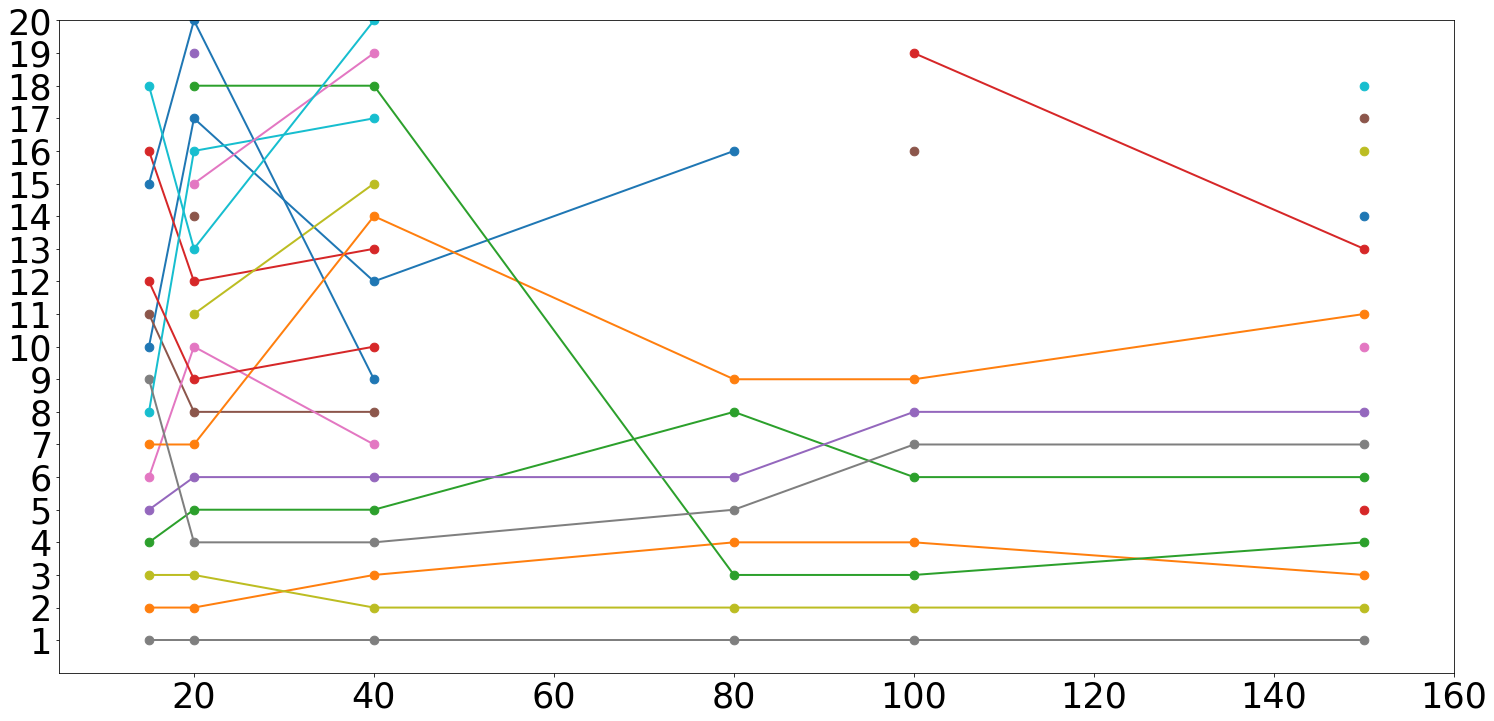

In [97]:
# Generating a nice looking plot.
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
for name in rankings_plotter_dict:
    x = rankings_plotter_dict[name]["cluster_sizes"]
    y = rankings_plotter_dict[name]["ranking"]
    ax.scatter(x, y, label=name, s=75)
    ax.plot(x, y, linewidth=2.0)
    # plt.legend()
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
plt.ylim([0, 20])
plt.xlim([5, 160])
plt.rc('ytick', labelsize=35)
plt.rc('xtick', labelsize=35)
plt.show()

The next thing we need to check is the outlier threshold. Because the update_database notebook hardcodes this, we're going to do it all within this notebook, which will require an HDBAnomalyDetector. To do that, we'll also need a Pandas DB reader to populate the data frames.

In [100]:
from anomaly_tools import HDBAnomalyDetector
from database_tools import PandasDBReader

In [103]:
# Some routines to make it a bit simpler.
def get_df_with_counts(states, specialty, threshold):
    pdb_reader = PandasDBReader("./config.yaml", states, specialty)
    hdb = HDBAnomalyDetector(regression_vars, response_var, pdb_reader.d_f, use_response_var=True)
    hdb.get_outlier_scores(min_size=15)
    return hdb.get_most_frequent(percent=threshold)

def build_new_table_data(states, specialty, threshold):
    counted_df = get_df_with_counts(states, specialty, threshold)
    new_table_data = {
        'state': [ginfo['state'] for ginfo in counted_df['address'].values],
        'lastname': counted_df['last_name'],
        'provider_type': [specialty[0] for i in range(len(list(counted_df.index)))],
        'outlier_count': counted_df['outlier_count']
    }
    return pd.DataFrame(data=new_table_data, index=list(counted_df.index))

In [112]:
# Now we make a similar list for the outlier threshold.
top_20_dict = {}
specialty = ["Internal Medicine"]
state = ["FL"]
for percent in [2, 4, 6, 8, 10]:
    sorted_data_frame = build_new_table_data(state, specialty, percent)
    top_20_dict[percent] = list(sorted_data_frame.head(20)['lastname'].values)
print(top_20_dict)

{8: ['RODRIGUEZ', 'WASSERMAN', 'COWEN', 'IYER', 'GUPTA', 'GOMER', 'SZYDLOWSKI', 'TAWFIK', 'ANAND', 'BRASSLOFF', 'SOFI', 'ST MARTIN', 'LECLERCQ', 'BARQUET', 'SIMMONS', 'LOPEZ', 'KHANNA', 'SANTI', 'BECK', 'MEHLMAN'], 2: ['RODRIGUEZ', 'WASSERMAN', 'COWEN', 'IYER', 'LECLERCQ', 'GUPTA', 'WENK', 'BARQUET', 'HARRIS', 'TAWFIK', 'MUBARAK', 'GOMER', 'ALBERTI FLOR', 'ANAND', 'KHANNA', 'MALONE', 'MIRZA', 'KAPADIA', 'HARDOON', 'LOPEZ'], 4: ['RODRIGUEZ', 'WASSERMAN', 'COWEN', 'IYER', 'GUPTA', 'GOMER', 'LECLERCQ', 'BARQUET', 'WENK', 'KHANNA', 'TAWFIK', 'HARRIS', 'MUBARAK', 'SZYDLOWSKI', 'MALONE', 'DELBAKHSH', 'ANAND', 'LOPEZ', 'ARDEL', 'PARKER'], 10: ['RODRIGUEZ', 'COWEN', 'WASSERMAN', 'IYER', 'GUPTA', 'GOMER', 'TAWFIK', 'SZYDLOWSKI', 'SOFI', 'KHANNA', 'SANTI', 'BRASSLOFF', 'ANAND', 'CONRADO', 'TORRICELLI', 'LECLERCQ', 'MEHLMAN', 'LOPEZ', 'SIMMONS', 'IRANI'], 6: ['RODRIGUEZ', 'WASSERMAN', 'COWEN', 'IYER', 'GUPTA', 'SZYDLOWSKI', 'GOMER', 'LECLERCQ', 'TAWFIK', 'WENK', 'BRASSLOFF', 'KHANNA', 'ST MARTIN'

In [113]:
rankings_dict = {8: ['RODRIGUEZ', 'WASSERMAN', 'COWEN', 'IYER', 'GUPTA', 'GOMER', 'SZYDLOWSKI', 'TAWFIK', 'ANAND', 'BRASSLOFF', 'SOFI', 'ST MARTIN', 'LECLERCQ', 'BARQUET', 'SIMMONS', 'LOPEZ', 'KHANNA', 'SANTI', 'BECK', 'MEHLMAN'], 2: ['RODRIGUEZ', 'WASSERMAN', 'COWEN', 'IYER', 'LECLERCQ', 'GUPTA', 'WENK', 'BARQUET', 'HARRIS', 'TAWFIK', 'MUBARAK', 'GOMER', 'ALBERTI FLOR', 'ANAND', 'KHANNA', 'MALONE', 'MIRZA', 'KAPADIA', 'HARDOON', 'LOPEZ'], 4: ['RODRIGUEZ', 'WASSERMAN', 'COWEN', 'IYER', 'GUPTA', 'GOMER', 'LECLERCQ', 'BARQUET', 'WENK', 'KHANNA', 'TAWFIK', 'HARRIS', 'MUBARAK', 'SZYDLOWSKI', 'MALONE', 'DELBAKHSH', 'ANAND', 'LOPEZ', 'ARDEL', 'PARKER'], 10: ['RODRIGUEZ', 'COWEN', 'WASSERMAN', 'IYER', 'GUPTA', 'GOMER', 'TAWFIK', 'SZYDLOWSKI', 'SOFI', 'KHANNA', 'SANTI', 'BRASSLOFF', 'ANAND', 'CONRADO', 'TORRICELLI', 'LECLERCQ', 'MEHLMAN', 'LOPEZ', 'SIMMONS', 'IRANI'], 6: ['RODRIGUEZ', 'WASSERMAN', 'COWEN', 'IYER', 'GUPTA', 'SZYDLOWSKI', 'GOMER', 'LECLERCQ', 'TAWFIK', 'WENK', 'BRASSLOFF', 'KHANNA', 'ST MARTIN', 'BARQUET', 'LOPEZ', 'ANAND', 'MUBARAK', 'PARKER', 'SOFI', 'SIMMONS']}

# Getting a more plot-able form of the rankings dictionary.
rankings_plotter_dict = {}
names_to_check = rankings_dict[2]  # We use 20 in the web-app, so let's use that for comparison.
for name in names_to_check:
    for m_s in sorted([key for key in rankings_dict]):
        if name not in rankings_plotter_dict:
            rankings_plotter_dict[name] = {"cluster_sizes": [], "ranking": []}
        rankings_plotter_dict[name]["cluster_sizes"].append(m_s)
        if name not in rankings_dict[m_s]:
            rankings_plotter_dict[name]["ranking"].append(None)
        else:
            rankings_plotter_dict[name]["ranking"].append(rankings_dict[m_s].index(name) + 1)  # Indexing starts at zero, naming doesn't.

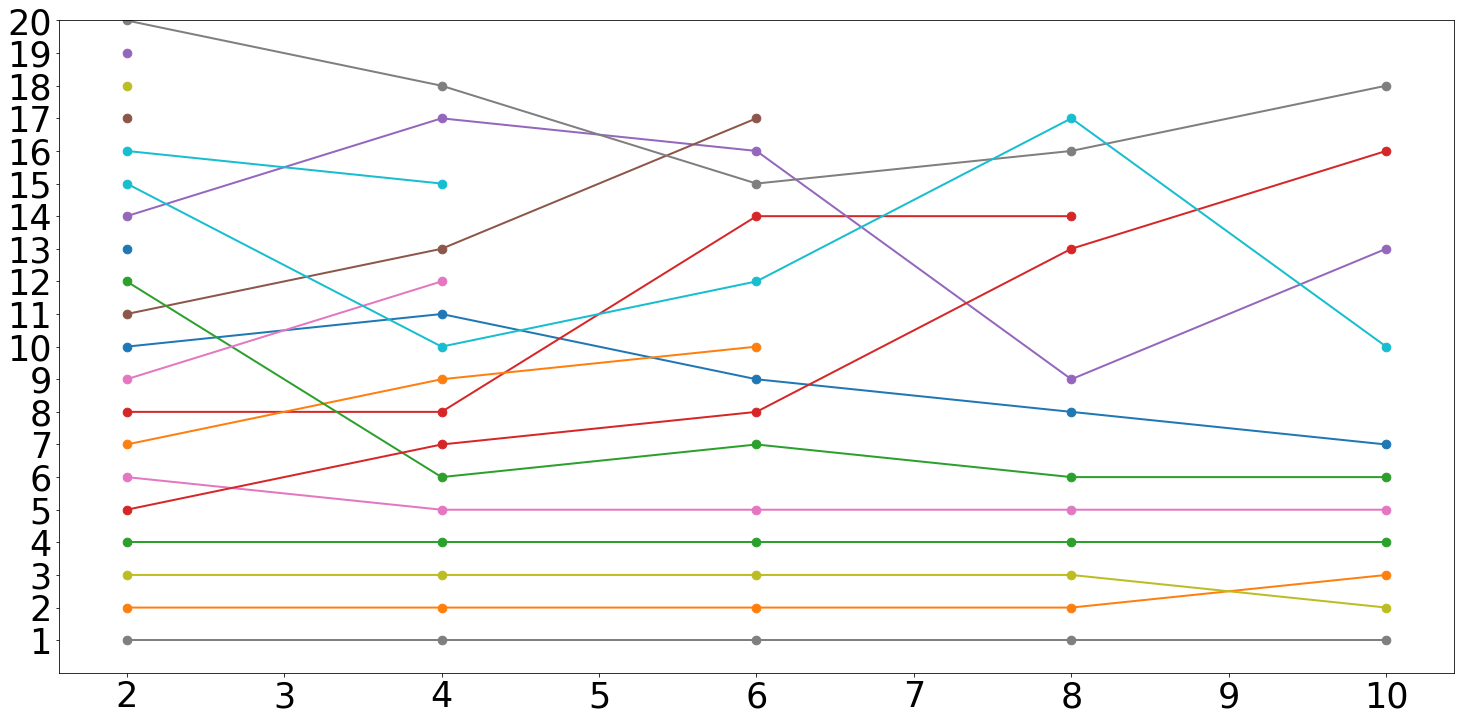

In [114]:
# Generating another nice looking plot.
plt.gcf().clear()
fig = plt.figure(figsize=(25, 12))
ax = fig.add_subplot(111)
for name in rankings_plotter_dict:
    x = rankings_plotter_dict[name]["cluster_sizes"]
    y = rankings_plotter_dict[name]["ranking"]
    ax.scatter(x, y, label=name, s=75)
    ax.plot(x, y, linewidth=2.0)
    # plt.legend()
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
plt.ylim([0, 20])
# plt.xlim([5, 160])
plt.rc('ytick', labelsize=35)
plt.rc('xtick', labelsize=35)
plt.show()